# Overview 

This notebook includes:
- LIME explanation for tabular data classification
- Classification task is predicting the risk of recidivism based on the COMPAS dataset
- Demo explaining Random Forest model with LimeTabularExplainer
- Coding Challenge: Implement the SHAP explanation for the same prediction


## Background
**Implementation of LIME for Tabular Data**

The source code of LIME is accessible over [Github](https://github.com/marcotcr/lime). 

In this notebook we are using Random Forest and Decision Tree classifiers.


This Notebook uses the COMPAS dataset that has been used in the highly cited ProPublica investigation demonstrating bias in machine learning.  Review 

https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm\

https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing 



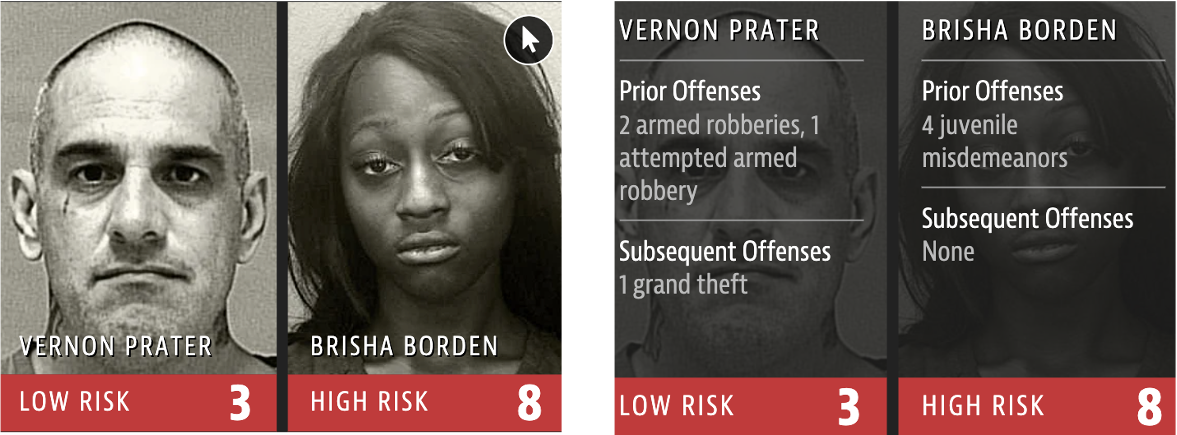

In [ ]:
# Install lime package using pip package manager in the current jupyter environment
!pip install lime

In [ ]:
import numpy as np
from lime.lime_tabular import LimeTabularExplainer

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Compass dataset is loaded from responsibly package
#from responsibly.dataset import COMPASDataset
import pandas as pd

RANDOM_SEED = 426

In [ ]:
# The pre-processing code is borrowed from Fooling-LIME-SHAP's github repository: https://github.com/dylan-slack/Fooling-LIME-SHAP/blob/master/get_data.py
def get_and_preprocess_compas_data():
	"""Handle processing of COMPAS according to: https://github.com/propublica/compas-analysis
	
	Parameters
	----------
	params : Params
	Returns
	----------
	Pandas data frame X of processed data, np.ndarray y, and list of column names
	"""

	PROTECTED_CLASS = 1
	UNPROTECTED_CLASS = 0
	POSITIVE_OUTCOME = 1
	NEGATIVE_OUTCOME = 0
  
	compas_df = pd.read_csv('https://raw.githubusercontent.com/rehmanzafar/workshop_datasets/main/compas-scores-two-years.csv', index_col=0)
	compas_df = compas_df.loc[(compas_df['days_b_screening_arrest'] <= 30) &
							  (compas_df['days_b_screening_arrest'] >= -30) &
							  (compas_df['is_recid'] != -1) &
							  (compas_df['c_charge_degree'] != "O") &
							  (compas_df['score_text'] != "NA")]

	compas_df['length_of_stay'] = (pd.to_datetime(compas_df['c_jail_out']) - pd.to_datetime(compas_df['c_jail_in'])).dt.days
	X = compas_df[['age', 'two_year_recid','c_charge_degree', 'race', 'sex', 'priors_count', 'length_of_stay']]

	# if person has high score give them the _negative_ model outcome
	y = np.array([NEGATIVE_OUTCOME if score == 'High' else POSITIVE_OUTCOME for score in compas_df['score_text']])
	sens = X.pop('race')

	# assign African-American as the protected class
	X = pd.get_dummies(X)
	sensitive_attr = np.array(pd.get_dummies(sens).pop('African-American'))
	X['race'] = sensitive_attr

	# make sure everything is lining up
	assert all((sens == 'African-American') == (X['race'] == PROTECTED_CLASS))
	cols = [col for col in X]
	
	return X, y, cols

## Fetching data

This dataset is availabe at Github repository:
https://raw.githubusercontent.com/rehmanzafar/workshop_datasets/main/compas-scores-two-years.csv

In [ ]:
X, y, cols = get_and_preprocess_compas_data()

In [ ]:
# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED )

### Model training - Random Forest

The first model will be trained with the mean dataset using all variables.

In [ ]:
rf = RandomForestClassifier(n_estimators=20, random_state=RANDOM_SEED)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=426,
                       verbose=0, warm_start=False)

In [ ]:
metrics.accuracy_score(y_test, rf.predict(X_test))

0.8080971659919028

In [ ]:
# Classifier prediction
idx = np.random.randint(0, X_test.shape[0])
class_labels = ["High", "Low"]
class_labels[rf.predict([X_test.iloc[idx]])[0]]

'Low'

In [ ]:
# classifier parameters
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 426,
 'verbose': 0,
 'warm_start': False}

### Create the explainer
For tabular data, LIME needs the dataset used for the training step.

In [ ]:
# kernel_width is hyperparameter that is used to define the boundary of local regions in which LIME is going to sampling within. 
# We are using None which means, defaults to sqrt (number of columns) * 0.75.

# feature_selection establishes the strategy that LIME will use for selecting the most important features for the prediction.
# discretize_continuous, if True, all non-categorical features will be discretized into quartiles.
explainer = LimeTabularExplainer(training_data = X_train,
                                 kernel_width = None,
                                 feature_names = cols, 
                                 class_names = class_labels, 
                                 discretize_continuous=False) 

### Explaining an instance

In [ ]:
# pick a random instance to explain
idx = np.random.randint(0, X_test.shape[0]) 

# data_row is the test instance that the model is going to explain.
# predict_fn is the function that will be used for making predictions.
# num_features specifies the number important features.
# num_samples defines, how many samples LIME needs to generate to train local model.
exp = explainer.explain_instance(data_row = X_test.iloc[idx], 
                                 predict_fn = rf.predict_proba, 
                                 num_features=5, 
                                 num_samples=5000) 

In [ ]:
# This is the prediction probability by the RandomForest classifier
rf.predict_proba(np.expand_dims(X_test.iloc[idx], axis=0))

array([[0., 1.]])

In [ ]:
# Plotting the LIME explanation
exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
# The class with the higher probability is the local prediction of LIME
exp.predict_proba


array([0., 1.])

In [ ]:
# R_squared is a measure of local fit. 
# The score range is from 0 to 1. 
# 0 is a poor fit and 1 is a good fit.
exp.score

0.4657882073245794

In [ ]:
# Local feature importance list. This is the same list of feature that are shown in LIME plot.
exp.as_list()

[('age', 0.12137404225392628),
 ('priors_count', -0.09111076761281582),
 ('two_year_recid', -0.05059110770935168),
 ('length_of_stay', -0.035866732785466454),
 ('race', -0.02502070996578854)]

**Understanding the Explanations**

The below list of features with their weights show the explanations generated with LIME. The weights of these features are computed after fitting a weighted linear model. The red bars in the image shows the negative coefficients and green bars shows the positive coefficients of the linear regression model. 

The positive coefficients indicates that the features support the prediction and the negative coefficients indicates the fetures contradict the prediction.

The size of the bars represents the feature importance of the features towards decicion made by the classifier. 

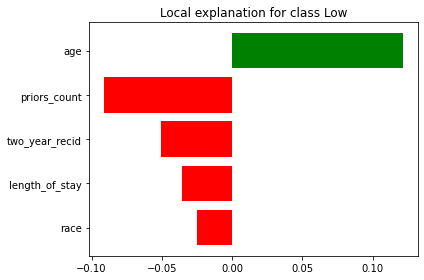

In [ ]:
# Visualize local feature importance
import matplotlib.pyplot as plt
exp.as_pyplot_figure()
plt.tight_layout()

In [ ]:
# Display predicted probabilities by LIME
exp.predict_proba

array([0., 1.])

### Model training - Decision Tree
A second model will be trained to demonstrate that LIME can be used to explain the predictions of any classifier 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
metrics.accuracy_score(y_test, dt.predict(X_test))

0.7789473684210526

In [ ]:
# Not this is the same explainer call made above for the random forest, the only thing that changes is we passed in the Decision Tree Classifier (dt) instead of the 
# Random Forest Classifier (rf)
idx = 60
exp = explainer.explain_instance(X_test.iloc[idx], dt.predict_proba, num_features=5, num_samples=1000) 

In [ ]:
exp.show_in_notebook(show_table=True, show_all=False)

# Explore LIME Package Documentation

In [ ]:
help( LimeTabularExplainer)

Help on class LimeTabularExplainer in module lime.lime_tabular:

class LimeTabularExplainer(builtins.object)
 |  Explains predictions on tabular (i.e. matrix) data.
 |  For numerical features, perturb them by sampling from a Normal(0,1) and
 |  doing the inverse operation of mean-centering and scaling, according to the
 |  means and stds in the training data. For categorical features, perturb by
 |  sampling according to the training distribution, and making a binary
 |  feature that is 1 when the value is the same as the instance being
 |  explained.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, training_data, mode='classification', training_labels=None, feature_names=None, categorical_features=None, categorical_names=None, kernel_width=None, kernel=None, verbose=False, class_names=None, feature_selection='auto', discretize_continuous=True, discretizer='quartile', sample_around_instance=False, random_state=None, training_data_stats=None)
 |      Init function.
 |      
 |    

# Coding Challenge:
- Implement the SHAP explanation for the same prediction.
- For Random Forest, obtain the global feature importance.
- Compare the feature explanations given by LIME, SHAP and Random Forest
- Experiment with changing the number of iterations and kernel width for LIME explanations